# Sprctrum trimming and signal syntesis

## The purpose of work

It is necessary to trim amplitude modulated signal specture by frequencies, then restore raw signal by syntesis.

## Imports of necessary libraries

In [1]:
%matplotlib notebook
from numpy import sin, cos, linspace, cumsum, asarray, zeros
from scipy.fft import rfft, rfftfreq, irfft, fft
from scipy.signal import square
from math import *
import matplotlib.pyplot as plt

## Core functions

In [2]:
# Static global variables to work with the signal
TIME_RANGE = 4      # Time range (sec)
FS         = 2048   # Sampling freq (Hz)
SAMPLES    = FS * TIME_RANGE # Count of samples


def t_step(samples=SAMPLES):
    """
    Generates a time steps array
    """
    TIME_STEP = 1 / FS # Sample time interval
    return linspace(0, TIME_RANGE, samples)


def signal(__func__):
    """
    Decorator function for restoring signal from mathematical function
    """
    def wrapper(A, k, w, q):
        t      = t_step()
        f      = [__func__(A, k, w, q, t=ti) for ti in t]
        return (t, f) 
    return wrapper


def syntesis(ys):
    """
     Function recreating a signal from the spectrum
    """
    yf = irfft(ys, norm='ortho')
    xf = t_step(len(yf))
    return (xf, yf)


def spectrum(yf):
    """
    Function realizing spectrum of signal
    """
    freq = rfftfreq(len(yf), 1 / FS)
    ampl = rfft(yf, norm='ortho')
    ampl[0] = 0
    return freq, ampl


def trim(ys, low, high): # BUG THERE
    """
    Method trimming signal by spectrum frequencies
    """
    ys = ys.copy()
    xs = rfftfreq(SAMPLES, 1 / FS)
    ys[:low]  = 0
    ys[high:] = 0
    return xs, ys


def modulation(harmonic, meander, type):
    """
    Function of modulation harmonic signal by meander.
    It can be modulated by amplitude, frequency and phase
    
    <type> parameter take values: 'ampl', 'freq', 'phase'
    """
    harms = len(harmonic[0])
    mends = len(meander[0])
    if harms != mends:
        raise ValueError(f'Dimensions and sizes of two signal arrays must be equal! Actual sizes: [{harms}], [{mends}]')
    
    def freq(harmonic, meander):
        f = []
        i, j = 0, 0
        while j < harms:
            f.append(harmonic[1][j])
            if meander[1][i] == 1:
                j += 2
            else: j += 1
            i += 1
                
        t = harmonic[0]
        
        #!!! Fitting the compressed array to its original size
        z = zeros(harms) # Creating zero array of size harms
        z[:len(f)] = f   # Pasting f array at start of zero array
        f = z
        return (t, f)

    modulate = {
        'ampl'  : [harmonic[0], [meander[1][i] * harmonic[1][i] for i in range(harms)]],
        'freq'  : freq(harmonic, meander),
        'phase' : [harmonic[0], [((meander[1][i] if meander[1][i] == 1 else -1) * harmonic[1][i]) for i in range(harms)]]
    }
    return asarray(modulate[type])


def restore_decay(x, A, k, a=0):
    """
    Additive fade-restore function
    """
    y = [dump(xi, A, k) + a for xi in x]
    return (y, [-yi for yi in y])


def dump(t, A, k=0):
    """
    Additive function to compute dumping function amplitude
    """
    return A * exp(-k * t)

## Additive functions for plotting image

In [3]:
def ylabel(axes, label):
    """
    Method for setting y label to subplots
    """
    for axis in axes:
        axis.set_ylabel(label)

        
def xlabel(axes, label):
    """
    Method for setting x label to subplots
    """
    for axis in axes:
        axis.set_xlabel(label)
        
        
def grid(axes):
    """
    Method for drawing grid on subplots
    """
    for axis in axes:
        axis.grid()
        
        
def xlim(axes, lim):
    """
    Method for setting the x bounds of the displayed function on subplots
    """ 
    if len(lim) == 1:
        for i, axis in enumerate(axes):
            axis.set_xlim(lim[0])
    else:
        if len(axes) != len(lim):
            raise ValueError(f'Sizes of axes array and limits array must be equal! Actual sizes: [{len(axes)}], [{len(lim)}]')
        for i, axis in enumerate(axes):
            axis.set_xlim(lim[i])

            
def ylim(axes, lim):
    """
    Method for setting the y bounds of the displayed function on subplots
    """ 
    if len(lim) == 1:
        for i, axis in enumerate(axes):
            axis.set_xlim(lim[0])
    else:
        if len(axes) != len(lim):
            raise ValueError(f'Sizes of axes array and limits array must be equal! Actual sizes: [{len(axes)}], [{len(lim)}]')
        for i, axis in enumerate(axes):
            axis.set_xlim(lim[i])


def draw(axes, funcs, ls='-', lw=1, color='tab:blue', fill='out'):
    """
    Mothod for plotting group of subplots
    """
    if len(axes) != len(funcs):
        raise ValueError(f'Sizes of axes array and functions array must be equal! Actual sizes: [{len(axes)}], [{len(funcs)}]')
        
    if fill == 'out':
        for i in range(len(axes)):
            axes[i].plot(*funcs[i], ls=ls, lw=lw, color=color)
    elif fill == 'in':
        for i in range(len(axes)):
            axes[i].fill_between(*funcs[i], ls=ls, lw=lw, color=color)

## Describing mathematical functions

In [4]:
A = 1.0
k = 0.0


@signal
def harmonic(A, k, w, q, t=None):
    """
    Function-wrapper for mathematical function
    """
    w *= 2*pi
    return dump(t, A, k) * sin(w * t + q)
    
    
@signal
def meander(A, k, w, q, t=None):
    """
    Function-wrapper for meander function
    """
    w *= 2 * pi
    sqr = square(w * t)
    return dump(t, A, k) * sqr if sqr >= 0 else 0

## Computing

In [5]:
# Computing raw signals (harmonic & meander)
xh, yh = harmonic(A, k, 16, 0)
xm, ym = meander(A, k, 2, 0)

# Computing modilated signals
xma, yma = modulation((xh, yh), (xm, ym), 'ampl')

# Computing spectrum
xsa, ysa = spectrum(yma)

# Cutting and syntesing signal
xsa, ysa = trim(ysa, 10, 100)
xma, yma = syntesis(ysa)

## Plotting

<IPython.core.display.Javascript object>


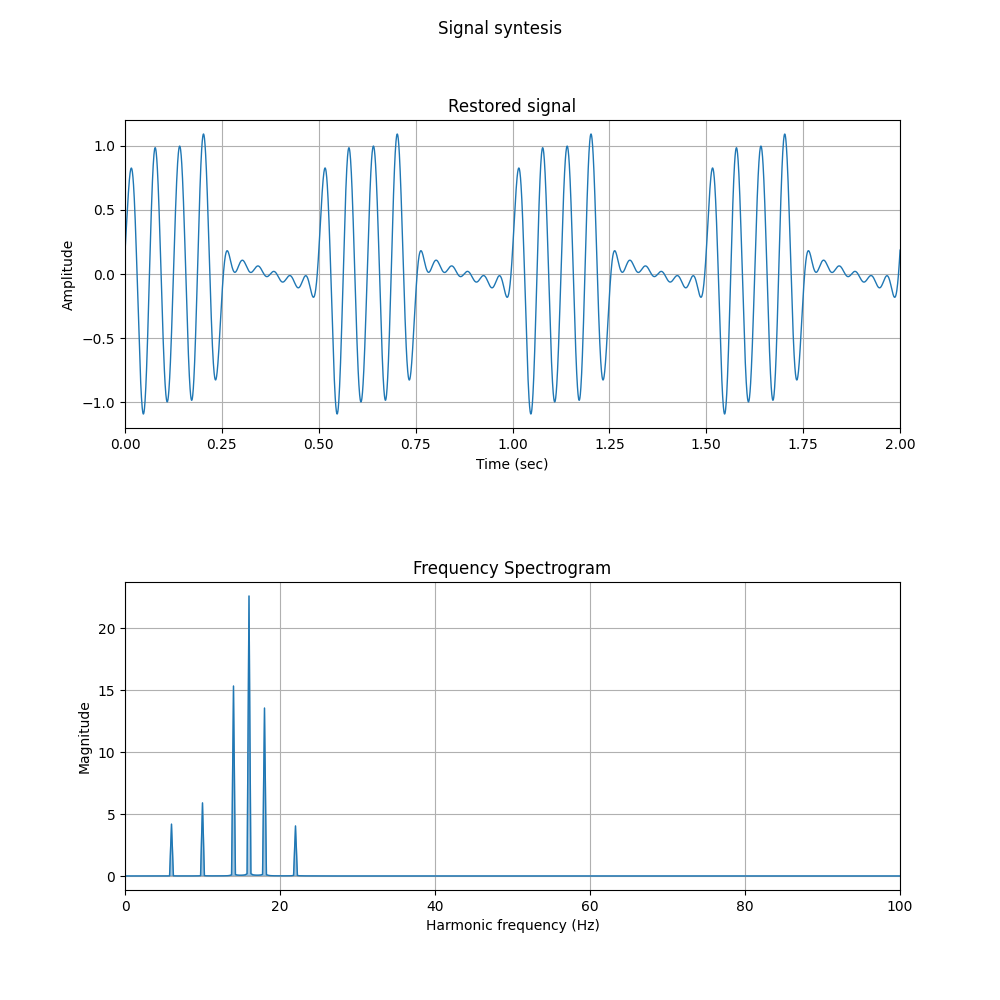

In [7]:
# Creation of figure and subplots
fig, ((af0, as0)) = plt.subplots(figsize=(10, 10), dpi=100, nrows=2)
fig.subplots_adjust(hspace=0.5)
fig.suptitle('Signal syntesis')
signal_axes   = fig.axes[::2]
spectrum_axes = fig.axes[1::2]

# Setting visible intervals
xlim(signal_axes, [(0, 2)])
xlim(spectrum_axes, [(0, 100)])

# Drawing grid
grid(signal_axes)
grid(spectrum_axes)

# Setting y labels
ylabel(signal_axes, 'Amplitude')
ylabel(spectrum_axes, 'Magnitude')

# Setting x labels
xlabel(signal_axes, 'Time (sec)')
xlabel(spectrum_axes, 'Harmonic frequency (Hz)')

# Setting column titles
signal_axes[0].set_title('Restored signal')
spectrum_axes[0].set_title('Frequency Spectrogram')

# Plotting
fill_color = (0.121, 0.464, 0.703, 0.39)

draw(signal_axes, [(xma, yma)])
draw(spectrum_axes, [(xsa, abs(ysa))], fill='out')
draw(spectrum_axes, [(xsa, abs(ysa))], color=fill_color, fill='in')